# Controlling the Time to Ruin

The time to ruin can be calculated using the following formula:

$$ T = \frac{S_0}{L_{net}} = \frac{S_0}{F \times P - (1 - F) \times R} $$

## Adjusting User Stake

Simply changing the user stake could allow users to reach ruin more or less quickly. However, the staked amount is a crucial factor. If set too high or too low, it might make it excessively difficult or too easy to enter the system. Therefore, it would be better to use another lever.

## Adjusting the Penalty/Recovery System

We can adjust $L_{net}$ to either decrease or increase the time to ruin.

$L_{net}$ can be seen as an affine function representing a user's loss per task as a function of their failure rate. It is negative between 0 and $F_t$ (since users shouldn't lose money if they engage in transactions with a failure rate below this threshold), and positive and increasing between $F_t$ and infinity. We want to increase the slope of this function so that a higher failure rate $x$ results in greater loss and, consequently, a shorter time to ruin:

$$ L_{net}(x) = x \times P - (1 - x) \times R $$

Expanding this gives us:

$$ L_{net}(x) = xP - (1 - x)R $$
$$ L_{net}(x) = xP - R + xR $$
$$ L_{net}(x) = xP + xR - R $$
$$ L_{net}(x) = x(P + R) - R $$

Therefore, the expanded function is:

$$ L_{net}(x) = x(P + R) - R $$

To increase the slope, we can multiply the coefficient $P + R$ by a factor $k > 1$:

$$ L_{net}(x) = x \times k(P + R) - R $$

As $x$ increases, the loss grows more rapidly, which shortens the time to ruin. However, by doing this, $L_{net}(F_t) = 0$ may no longer hold true for all $k$. We need this equality to guarantee a certain level of reliability.

Users need to maintain a failure rate below $\frac{R}{P + R}$ to stay profitable. Thus, this should equal our targeted failure rate, making it unprofitable for users to exceed this rate.

To ensure $R$ depends on $P$ such that the following always holds:

$$ F_t = \frac{R}{P + R} $$

We rearrange and solve:

$$ F_t \times (P + R) = R $$
$$ F_t \times P + F_t \times R = R $$
$$ F_t \times P = R - F_t \times R $$
$$ F_t \times P = R \times (1 - F_t) $$
$$ R = \frac{F_t \times P}{1 - F_t} $$

Inserting this into the net loss function gives us:

$$ L_{net}(x) = x \times (P + \frac{F_t \times P}{1 - F_t}) - \frac{F_t \times P}{1 - F_t} $$

Simplifying further:

$$ L_{net}(x) = x \times \frac{P}{1 - F_t} - \frac{F_t \times P}{1 - F_t} $$

Now, we can adjust $P$ to modify the slope of our function while keeping $L_{net}(F_t) = 0$ valid. However, we are limited by the maximum stake, as excessive slashing risks causing significant losses for users who are simply unlucky.

## Plotting


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the overall task failure rate
def calculate_failure_rate(F_u, mean_F_u):
    return 1 - (1 - F_u) * (1 - mean_F_u) ** 3

# Function to calculate the net loss in stake per task
def net_loss_per_task(F, P, F_t):
    # We'll add our modification here
    return (F*P)/(1-F_t) - (F_t * P)/(1-F_t)

# Generate a long-tailed distribution for user failure rates (F_u)
shape, scale = 1.0, 0.01  # shape (alpha) and scale (xmin) parameters for the Pareto distribution
F_u_values = (np.random.pareto(shape, 1000) + 1) * scale

# Ensure that failure rates are within a realistic range [0, 1]
F_u_values = np.clip(F_u_values, 0, 1)

# Calculate the mean failure rate from the generated distribution
mean_F_u = np.mean(F_u_values)

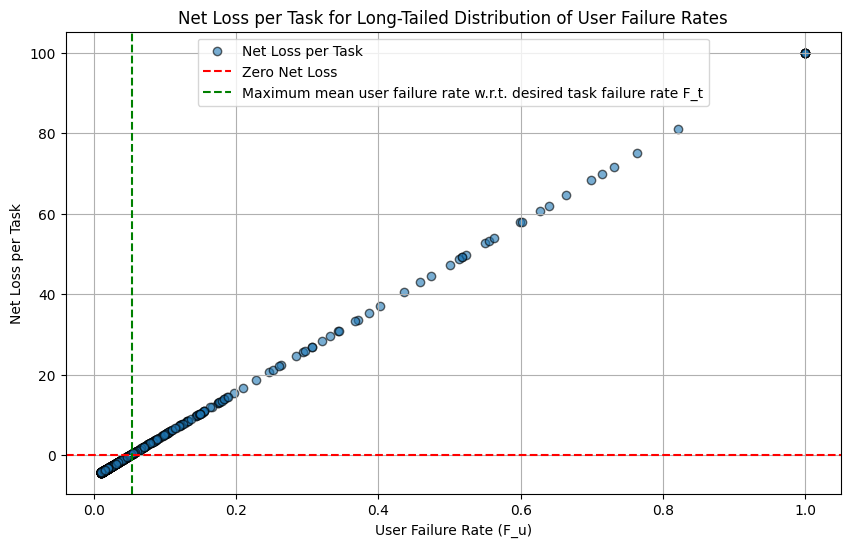

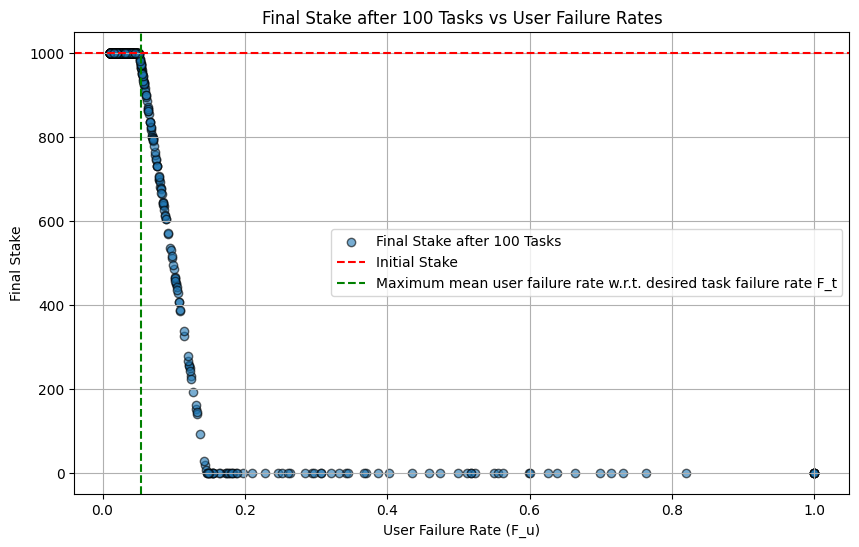

In [8]:
# Parameters
S_0 = 1000  # initial stake
P = 100     # penalty per task failure
F_t = 0.2      # desired failure rate
num_tasks = 100  # number of tasks

# Calculate overall task failure rate and net loss per task for each user failure rate
F_values = calculate_failure_rate(F_u_values, mean_F_u)
L_net_values = net_loss_per_task(F_values, P, F_t)

# Initialize stakes as float
stakes = np.full(F_u_values.shape, S_0, dtype=float)

# Simulate the evolution of stakes over 200 tasks
for _ in range(num_tasks):
    stakes += -L_net_values
    stakes = np.maximum(stakes, 0)  # Ensure stakes do not fall below 0
    stakes = np.minimum(stakes, S_0)  # Ensure stakes do not fall below 0

# Plot the net loss per task for the long-tailed distribution of user failure rates
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, L_net_values, alpha=0.6, edgecolor='black', label='Net Loss per Task')
plt.axhline(0, color='r', linestyle='--', label='Zero Net Loss')
plt.axvline(1-(1-F_t)**(1/4), color='g', linestyle='--', label='Maximum mean user failure rate w.r.t. desired task failure rate F_t')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Net Loss per Task')
plt.title('Net Loss per Task for Long-Tailed Distribution of User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()

# Plot the final stakes after 200 tasks
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, stakes, alpha=0.6, edgecolor='black', label='Final Stake after '+ str(num_tasks) +' Tasks')
plt.axhline(S_0, color='r', linestyle='--', label='Initial Stake')
plt.axvline(1-(1-F_t)**(1/4), color='g', linestyle='--', label='Maximum mean user failure rate w.r.t. desired task failure rate F_t')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Final Stake')
plt.title('Final Stake after '+ str(num_tasks) +' Tasks vs User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()


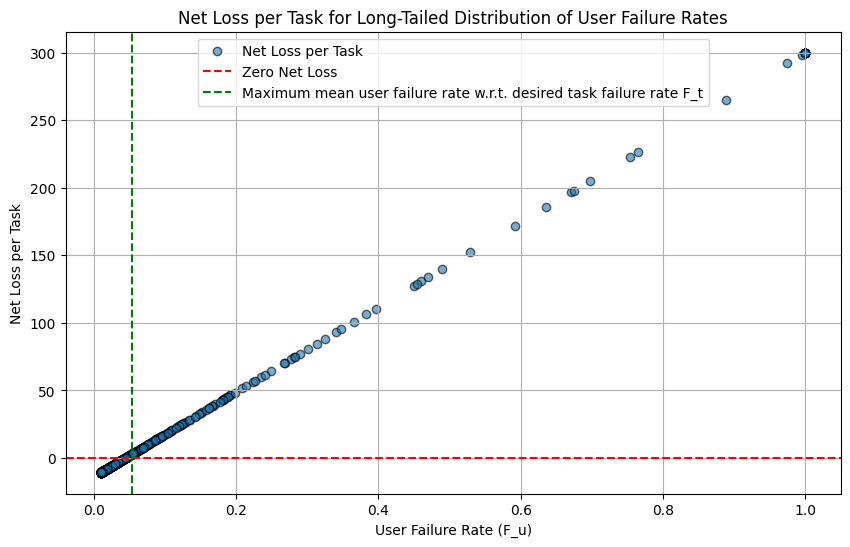

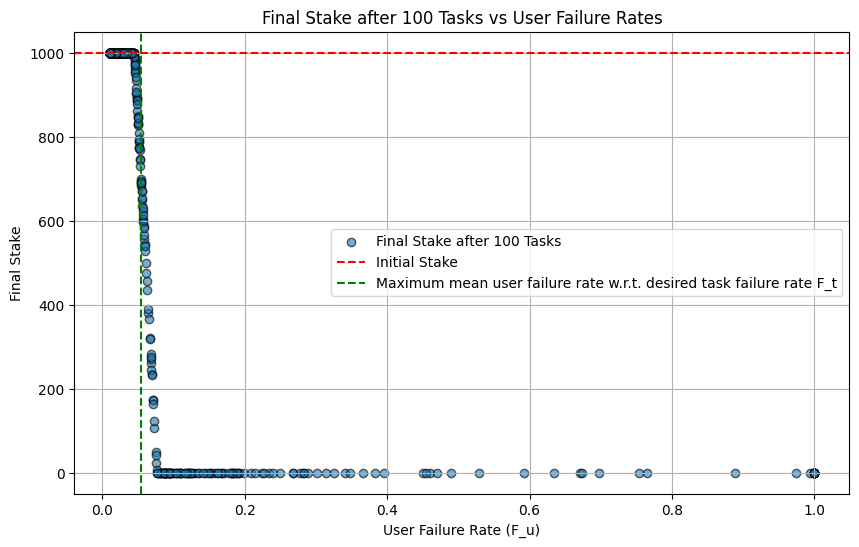

In [9]:
# Parameters
S_0 = 1000  # initial stake
P = 300     # penalty per task failure
F_t = 0.2      # desired failure rate
num_tasks = 100  # number of tasks

# Generate a long-tailed distribution for user failure rates (F_u)
shape, scale = 1.0, 0.01  # shape (alpha) and scale (xmin) parameters for the Pareto distribution
F_u_values = (np.random.pareto(shape, 1000) + 1) * scale

# Ensure that failure rates are within a realistic range [0, 1]
F_u_values = np.clip(F_u_values, 0, 1)

# Calculate the mean failure rate from the generated distribution
mean_F_u = np.mean(F_u_values)

# Calculate overall task failure rate and net loss per task for each user failure rate
F_values = calculate_failure_rate(F_u_values, mean_F_u)
L_net_values = net_loss_per_task(F_values, P, F_t)

# Initialize stakes as float
stakes = np.full(F_u_values.shape, S_0, dtype=float)

# Simulate the evolution of stakes over 200 tasks
for _ in range(num_tasks):
    stakes += -L_net_values
    stakes = np.maximum(stakes, 0)  # Ensure stakes do not fall below 0
    stakes = np.minimum(stakes, S_0)  # Ensure stakes do not fall below 0

# Plot the net loss per task for the long-tailed distribution of user failure rates
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, L_net_values, alpha=0.6, edgecolor='black', label='Net Loss per Task')
plt.axhline(0, color='r', linestyle='--', label='Zero Net Loss')
plt.axvline(1-(1-F_t)**(1/4), color='g', linestyle='--', label='Maximum mean user failure rate w.r.t. desired task failure rate F_t')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Net Loss per Task')
plt.title('Net Loss per Task for Long-Tailed Distribution of User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()

# Plot the final stakes after 200 tasks
plt.figure(figsize=(10, 6))
plt.scatter(F_u_values, stakes, alpha=0.6, edgecolor='black', label='Final Stake after '+ str(num_tasks) +' Tasks')
plt.axhline(S_0, color='r', linestyle='--', label='Initial Stake')
plt.axvline(1-(1-F_t)**(1/4), color='g', linestyle='--', label='Maximum mean user failure rate w.r.t. desired task failure rate F_t')
plt.xlabel('User Failure Rate (F_u)')
plt.ylabel('Final Stake')
plt.title('Final Stake after '+ str(num_tasks) +' Tasks vs User Failure Rates')
plt.legend()
plt.grid(True)
plt.show()

## Real world slashing translation

In practice we wannot simply apply the function and compute the net loss of a user in this way. We don't know in advance the user failure rate and we need to act with a limited knowledge on each task execution.  
The challenge here if we want to modify the slashing penalty is to respect the defined ratio so that everyone that is below our targeted failure rate stays profitable.  
For that purpose if we consider a constant penalty, the recovery amount should be computed based on that penalty. But the problem might get more tricky as we move on to a changing penalty (based on repeated failed tasks or on tasks size for example...)  